In [ ]:
# Import libraries
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data() # Unpack the data

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
original_dim = 28 * 28 # 784
intermediate_dim = 64 # we need to learn 64 latent variables. For each of these variables, we need to learn mu & sigma
latent_dim = 2 # for mu & sigma - one for each

inputs = keras.Input(shape=(original_dim,)) #28 * 28 = 784
h = layers.Dense(intermediate_dim, activation='relu')(inputs) # h -> Hidden layer
z_mean = layers.Dense(latent_dim)(h) # 2 latent dimensions on top of the hidden layer
z_log_sigma = layers.Dense(latent_dim)(h) # We are trying to learn the log transformed version of sigma

In [ ]:
from tensorflow.keras import backend as K
# Function for sampling for image creation
def sampling(args): # args -> aruguments - z_mean & z_log_sigma from the previous layer
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), # epsilon is drawn from normal distribution for training purposes
                                 mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon # Expected value of x

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2]) # VAE model instantiation
# Model - vae
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim # for all the 784 pixels, we need to compute reconstruction loss
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma) # KL Divergence loss
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 8s 4ms/step - loss: 184.8968 - val_loss: 166.4434
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 164.3869 - val_loss: 163.0114
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 161.9031 - val_loss: 161.2267
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 160.2000 - val_loss: 159.6466
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 158.7876 - val_loss: 158.4756
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 157.4759 - val_loss: 157.2371
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 156.2264 - val_loss: 155.9071
Epoch 8/100
1875/1875 [==============================] - 8s 4ms/step - loss: 155.1663 - val_loss: 155.1910
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 154.2481 - val_loss: 154.2076
Epoch 10/100
1875/1875 [=============

In [ ]:
from matplotlib import pyplot as plt

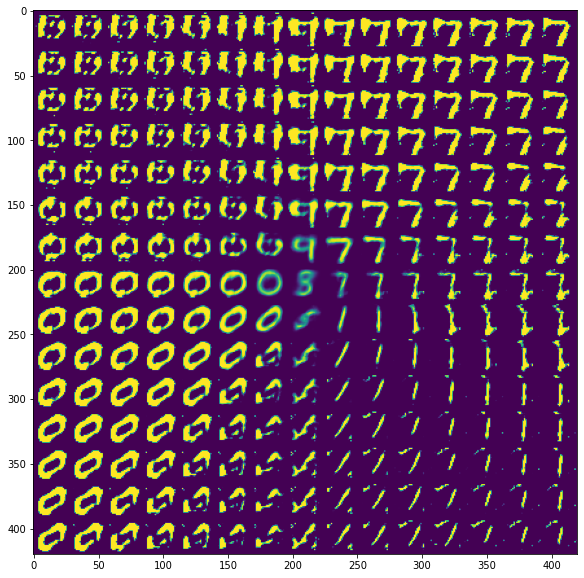

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()